# Volatility Forecasting with GARCH Model

## Table of Content:
* [1. Introduction](#intro)
* [2. Data Preparation](#data_prep)
    * [2.1 Extracting Data with Alpha Vantage](#extract)
    * [2.2 Exploratory Data Analysis of Time Series Data](#eda)
* [3. GARCH Model Implementation](#garch)
    * [3.1 Forecasting Volatility](#forecast)
    * [3.2 Model Evaluation](#evaluate)
* [4. Conclusion](#conclusion)

## 1. Introduction <a class="anchor" id="intro"></a>

Volatility in the stock market indicates uncertainty and risk, indicating the frequency and magnitude of price fluctuations. High volatility indicates greater risk, while low volatility suggests potential profit or loss opportunities. Investors, analysts, and policymakers closely monitor volatility to influence investment decisions and risk management techniques.

Volatility forecasting is crucial for market participants as it aids in risk assessment, management, and optimization of portfolio performance. Accurate forecasts enable investors to make informed decisions about asset allocation and trading strategies, and are essential for option pricing models. They also help identify periods of increased risk or opportunity, thereby enhancing overall investment returns. GARCH (Generalized Autoregressive Conditional Heteroskedasticity) model is one of the fundamental tools for forecasting volatility in financial markets:

- Autoregressive (AR) Component: Autoregressive elements in GARCH model capture the dependency of current volatility on past volatility levels, enabling the model to forecast future volatility based on historical patterns.

- Heteroskedasticity: Heteroskedasticity refers to the phenomenon where the variance of a time series changes over time. GARCH model addresses this by modeling volatility as a function of past squared residuals, allowing for adaptive forecasting in the presence of varying volatility levels.

By capturing the autoregressive and conditional heteroskedastic properties of asset returns, GARCH model provides insights into future volatility dynamics, recognizing the clustering nature of volatility and adapting forecasts accordingly.


This project employs AAPL as a testing sample to illustrate the practical application of GARCH Model in volatility forecasting. By utilizing Python, it demonstrates the step-by-step process of fitting a GARCH model to historical AAPL data, analyzing its performance, and generating volatility forecasts.

## 2. Data Preparation <a class="anchor" id="data_prep"></a>

This section involves extracting daily stock data from Alpha Vantage and conducting data wrangling procedures. Subsequently, we will analyze the time series data through Autocorrelation Function (ACF) and Partial Autocorrelation Function (PACF) plots. Finally, the dataset will be divided into training and testing subsets for model development and evaluation, respectively.

In [195]:
# automatically reloading modules before executing code
%load_ext autoreload
# autoreload to level 2, ensuring modules are reloaded for every execution
%autoreload 2 

# import libraries
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from arch import arch_model
import garch_kit as gk
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### 2.1 Extracting Data with Alpha Vantage <a class="anchor" id="extract"></a>



In [196]:
#import library for extracting stock data from Alpha Vantage
from alpha_vantage.timeseries import TimeSeries

# set the output as DataFrame instead of dictionary
ts = TimeSeries(key='own_api_key',output_format='pandas') #ENTER own API KEY

# set the output format to pandas
data, meta_data = ts.get_daily('AAPL', outputsize='full')

# remove numbering from columns
data.columns = [c.split(". ")[1] for c in data.columns]

# wrangle data to convert daily stock prices to daily returns
df_aapl = gk.wrangle_data(data).iloc[-504:]
df_aapl.head(5)

date
2022-05-11   -5.323339
2022-05-12   -2.726246
2022-05-13    3.141764
2022-05-16   -1.072964
2022-05-17    2.510479
Name: log return, dtype: float64

### 2.2 Exploratory Data Analysis of Time Series Data <a class="anchor" id="eda"></a>

Autocorrelation Function (ACF) plots show correlations between a time series and its lagged values. Positive correlations indicate persistence or trend, while negative correlations imply an inverse relationship. Significant spikes may indicate seasonality or trend, while rapid decay suggests randomness. ACF plots aid in identifying autoregressive (AR) and moving average (MA) terms in time series modeling, including GARCH model for volatility forecasting.

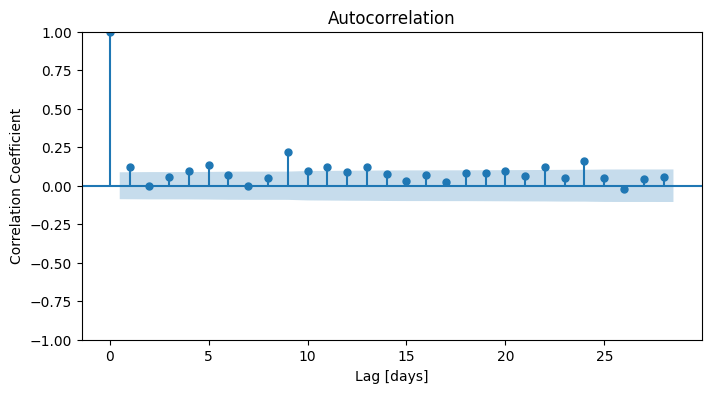

In [197]:
# create an ACF plot for the AAPL stock
fig, ax = plt.subplots(figsize=(8, 4))
plot_acf(df_aapl**2, ax=ax)
plt.xlabel("Lag [days]")
plt.ylabel("Correlation Coefficient");

In the Autocorrelation Function (ACF) plot, a slight exceedance of the blue area at 24 lag days suggests a potential significant correlation at that interval. This likely indicates a recurring pattern or seasonality in the data, relevant for GARCH modeling in volatility forecasting. Further analysis is warranted to understand the underlying factors driving this correlation and its implications for model accuracy and predictive performance.

Autocorrelation Function (ACF) plots reveal correlations between a time series and its lagged values, providing overall correlation patterns. Partial Autocorrelation Function (PACF) plots show direct correlations, aiding in identifying specific lag orders for autoregressive (AR) terms. PACF plots enhance understanding of past observations' direct influence on present values, enhancing predictive power in time series modeling.

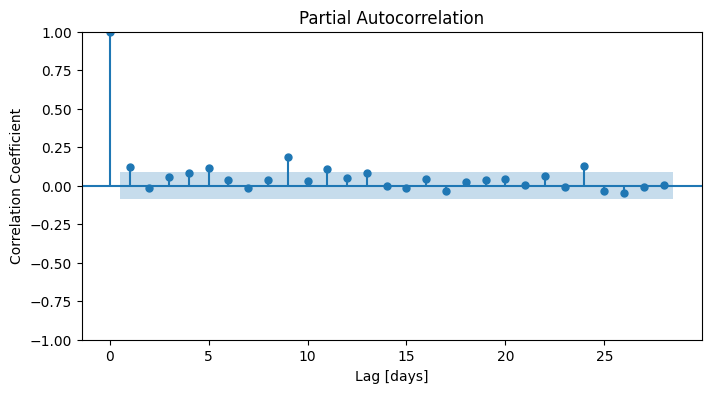

In [198]:
# create an PACF plot for the AAPL stock
fig, ax = plt.subplots(figsize=(8, 4))
plot_pacf(df_aapl**2, ax=ax)
plt.xlabel("Lag [days]")
plt.ylabel("Correlation Coefficient");

A correlation coefficient exceeding the threshold at 24 lag days in a PACF plot indicates a direct correlation between observations 24 time periods apart. This suggests a potential need for an autoregressive term of order 24 in the time series model to adequately capture the predictive power of these distant past values on present observations.

In [199]:
# create a training set that contains the first 80% of the data
cutoff_test = int(len(df_aapl) * 0.8)
df_aapl_train = df_aapl.iloc[:cutoff_test]
df_aapl_train.tail(8)

date
2023-12-06   -0.570334
2023-12-07    1.008829
2023-12-08    0.738503
2023-12-11   -1.301157
2023-12-12    0.788888
2023-12-13    1.655372
2023-12-14    0.075744
2023-12-15   -0.272948
Name: log return, dtype: float64

## 3. GARCH Model Implementation <a class="anchor" id="garch"></a>

GARCH model operate on two fundamental principles: 

- autoregressive forecasting (AR), where future predictions are based on past information (captured by $\alpha$), and 
- conditional heteroskedasticity (CH), which acknowledges that the model's predictions can vary over time, introducing variability at each time stamp (captured by $\beta$). 

Within a GARCH framework, three key components shape the volatility prediction process. Below is the formula for GARCH (1,1) Model:

$$\sigma_{T}^2=\omega+\alpha*r_{T-1}^2+\beta*\hat{\sigma}_{T-1}^2$$

1. Omega $\omega$: a long-run average variance, which establishes a baseline for the stock's volatility. 
2. Alpha $\alpha$ (p=1): accounts for past returns $r_{T-1}^2$, capturing the persistence of volatility trends over time. 
3. Beta $\beta$ (q=1): incorporates past predictions, adjusting for short-term shocks or innovations affecting volatility $\hat{\sigma}_{T-1}^2$.

The model iterates to strike the optimal balance among these components, seeking to deliver accurate volatility predictions with a forecasted volatility series $\sigma_{T}^2$.

### 3.1 Forecasting Volatility <a class="anchor" id="forecast"></a>

The GARCH(1, 1) model is often favored for its equilibrium of simplicity and efficacy. Featuring a single autoregressive term and one moving average term, it maintains a manageable complexity while effectively encapsulating essential facets of volatility dynamics. 

This simplicity fosters ease in interpretation, implementation, and estimation, rendering it applicable across diverse contexts. Supported by empirical validation across various financial datasets, the model enjoys widespread adoption among researchers and practitioners. 

In this session, the GARCH(1, 1) model will be applied to analyze financial time series datasets pertaining to AAPL, contributing to informed decision-making in financial analysis.

In [200]:
# build and train the GARCH(1, 1) model
model = arch_model(
    df_aapl_train,
    p=1,
    q=1,
    rescale=False
).fit(disp=0)

# show model summary
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                     Constant Mean - GARCH Model Results                      
==============================================================================
Dep. Variable:             log return   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:               -773.891
Distribution:                  Normal   AIC:                           1555.78
Method:            Maximum Likelihood   BIC:                           1571.78
                                        No. Observations:                  403
Date:                Tue, May 14 2024   Df Residuals:                      402
Time:                        11:02:02   Df Model:                            1
                                 Mean Model                                
===========================================================================
                 coef    std err          t      P>|t|     95.0% Conf. Int.
---------------------------------------------------------------------------
mu             0.1326  8.014e-02      1.654  9.814e-02 [-2.453e-02,  0.290]
                               Volatility Model                              
=============================================================================
                 coef    std err          t      P>|t|       95.0% Conf. Int.
-----------------------------------------------------------------------------
omega          0.0339  3.667e-02      0.925      0.355   [-3.797e-02,  0.106]
alpha[1]       0.0404  2.448e-02      1.651  9.882e-02 [-7.573e-03,8.839e-02]
beta[1]        0.9430  3.030e-02     31.123 1.191e-212      [  0.884,  1.002]
=============================================================================

Covariance estimator: robust
"""

Below code generates a time series plot illustrating the AAPL training data. It utilizes the gk.time_series_plot function, which accepts the AAPL training dataset (df_aapl_train) as input. Additionally, it incorporates information about the conditional volatility obtained from the model, enhancing the visualization with insights into volatility dynamics over time.

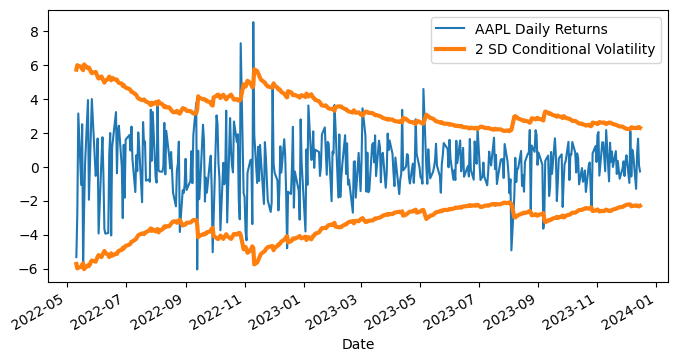

In [201]:
# create a time series plot with the AAPL train data
gk.time_series_plot(df_aapl_train, name="AAPL", model_con_vol=model.conditional_volatility)

### 3.2 Model Evaluation <a class="anchor" id="evaluate"></a>

In this section, we undertake a comprehensive assessment of the performance and reliability of GARCH Models through several criteria:

- Utilizing Partial Autocorrelation Function (PACF) plots, we identify the next highest correlation coefficient occurring at a 9-day lag, thereby prompting a comparison between GARCH (1, 1) and GARCH (9, 9) model using Akaike Information Criterion (AIC) and Bayesian Information Criterion (BIC) measures.

- We generate standardized residuals plots to evaluate the normality of residuals.

- Employing walk-forward validation, a method of out-of-sample testing, further enhances our assessment.

The Akaike Information Criterion (AIC) evaluates the goodness of fit of estimated statistical models, while the Bayesian Information Criterion (BIC) selects models from a finite set. To mitigate overfitting, which arises from adding parameters to improve model performance, BIC introduces a penalty term for model complexity. 

Both AIC and BIC serve as vital statistical measures, penalizing model complexity and aiding in the identification of optimal model specifications. Lower AIC and BIC values indicate superior model fit, facilitating the identification of models that strike a balance between accuracy and complexity.

In [202]:
# build and train the GARCH(9, 9) model
model_2 = arch_model(
    df_aapl_train,
    p=9,
    q=9,
    rescale=False
).fit(disp=0)

# show model summary
print(f"AIC of GARCH(9, 9) is {model_2.aic}.")
print(f"BIC of GARCH(9, 9) is {model_2.bic}.")
print(f"AIC of GARCH(1, 1) is {model.aic}.")
print(f"BIC of GARCH(1, 1) is {model.bic}.")

AIC of GARCH(9, 9) is 1574.24168119277.
BIC of GARCH(9, 9) is 1654.2204124317038.
AIC of GARCH(1, 1) is 1555.782139599427.
BIC of GARCH(1, 1) is 1571.7778858472136.


The GARCH(1, 1) model demonstrates superior performance based on both AIC and BIC criteria compared to the GARCH(9, 9) model. With lower AIC and BIC values, the GARCH(1, 1) model indicates a better balance between model accuracy and complexity. This suggests that the GARCH(1, 1) model may provide a more optimal specification for volatility forecasting in this context.

Text(0.5, 1.0, 'ACF of AAPL GARCH Model Standardized Residuals')

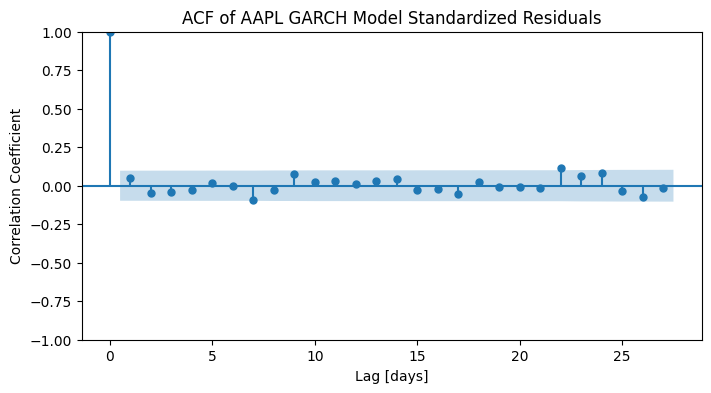

In [203]:
# create a standardized residuals plot

# Create `fig` and `ax`
fig, ax = plt.subplots(figsize=(8, 4))

# Create ACF of squared, standardized residuals
plot_acf(model.std_resid**2, ax=ax)

# Add axis labels
plt.xlabel("Lag [days]")
plt.ylabel("Correlation Coefficient");

# Add title
plt.title("ACF of AAPL GARCH Model Standardized Residuals")

When all correlation coefficients in the standardized residuals plot remain within the blue area, it indicates that the residuals exhibit no significant autocorrelation. This suggests that the GARCH model adequately captures the autocorrelation structure in the data, resulting in residuals that are statistically independent and do not exhibit any systematic patterns. Consequently, the model's assumptions regarding the absence of autocorrelation in the residuals are validated, enhancing the reliability of the model's forecasts.

y_test_wfv type: <class 'pandas.core.series.Series'>
y_test_wfv shape: (100,)


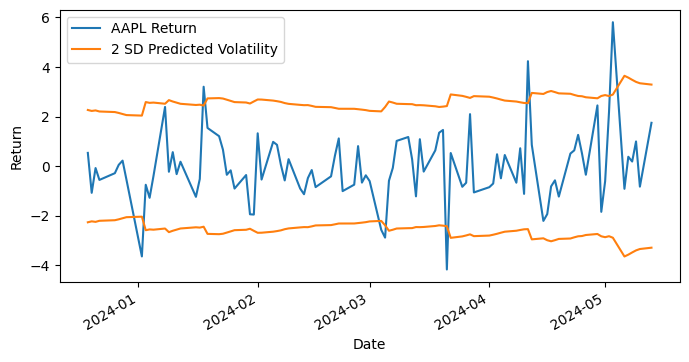

In [204]:
# perform a walk-forward validation
gk.walk_forward_valid(df_aapl, name="AAPL")

The walk-forward validation plot reveals that the majority of AAPL returns remain within 2 standard deviations of the predicted volatility, indicating strong agreement between the model's forecasts and actual market behavior. While a few points exceed this range, they likely represent occasional instances of heightened volatility not captured by the model. 

Overall, the plot underscores the effectiveness of the GARCH model in accurately predicting volatility dynamics, providing valuable insights for risk management and decision-making in financial markets.

In [205]:
# generate 5-day volatility forecast
prediction = model.forecast(horizon=5, reindex=False).variance**0.5
# generate formatted forecast
prediction_formatted = gk.clean_prediction(prediction)
prediction_formatted

{'2023-12-18T00:00:00': 1.0650176679462318,
 '2023-12-19T00:00:00': 1.0676058185145625,
 '2023-12-20T00:00:00': 1.0701327906843434,
 '2023-12-21T00:00:00': 1.0726004890630059,
 '2023-12-22T00:00:00': 1.0750107362303556}

Above numbers represent forecasted volatility levels of AAPL for respective dates, indicating the estimated standard deviation of returns over a 5-day period. 

This provides insights into the expected level of market volatility for each date listed.

## 4. Conclusion <a class="anchor" id="conclusion"></a>

In conclusion, this project has provided a foundational overview of GARCH Models and their practical application in volatility forecasting, demonstrated through the analysis of AAPL stock data. By leveraging Python and GARCH modeling techniques, we illustrated the step-by-step process of fitting a model, evaluating its performance, and generating volatility forecasts. 

However, it's important to note that this project only scratches the surface of GARCH Models, offering a basic understanding and simple example. Readers interested in delving deeper or exploring the various variants of the model for volatility forecasting are encouraged to pursue further reading and research.